<a href="https://colab.research.google.com/github/bfulroth/hello-world/blob/master/CSCI_S14A_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the HAM10000 dataset for possible skin cancer detection app

In [1]:
import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
#import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
#from tf_keras_vis.gradcam import Gradcam
#from tf_keras_vis.saliency import Saliency
#from tf_keras_vis.utils import normalize
import tqdm

import pandas as pd

%matplotlib inline

print(f"Using TensorFlow version: {tf.__version__}")
print(f"Using TensorFlow Datasets version: {tfds.__version__}")
#print(f"Using TensorFlow AddOns version: {tfa.__version__}")

Using TensorFlow version: 2.8.2
Using TensorFlow Datasets version: 4.0.1


In [2]:
# working_dir = pathlib.Path().absolute()
# os.chdir(working_dir)

In [3]:
# Confirm you are using Google's GPU's
tf.test.gpu_device_name()

''

In [4]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6789861432420443380
 xla_global_id: -1]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the metadata provided in the dataset download.  
#### *Note: this has the lesion label 'dx'*

In [6]:
df_meta = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
class_num = df_meta.dx.value_counts()
class_num

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [8]:
sum(df_meta.dx.value_counts())

10015

### Convert the lesion label to integers for the CNN

In [9]:
df_meta.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [10]:
dict_lesion_mp = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

# reverse the mapping dictionary for later...
dict_rev_lesion_mp = {v: k for k, v in dict_lesion_mp.items()}

df_meta['label'] = df_meta['dx'].map(dict_lesion_mp)
df_meta.head(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,0


In [11]:
# Need to find an image for our MVP presentation on 7/18

df_meta_mel_imgs = df_meta[df_meta['dx'] == 'mel']
df_meta_mel_imgs

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,3
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,3
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,3
1214,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,3
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,3
...,...,...,...,...,...,...,...,...
2319,HAM_0001953,ISIC_0025611,mel,histo,65.0,male,back,3
6769,HAM_0002552,ISIC_0032985,mel,histo,25.0,male,upper extremity,3
8820,HAM_0002552,ISIC_0032936,mel,histo,25.0,male,upper extremity,3
8834,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity,3


### Determine the weight of each class and store in a dictionary that is used during training...

In [12]:
dict_class_wt = {}

for idx, item in class_num.items():
  dict_class_wt[dict_lesion_mp[idx]] = item

dict_class_wt

{0: 1099, 1: 6705, 2: 115, 3: 1113, 4: 142, 5: 514, 6: 327}

### Create a tensorflow dataset that pairs the image with it's label

In [13]:
# step 1
filenames = tf.constant(list(df_meta['image_id']))
labels = tf.constant(list(df_meta['label']))

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file('/content/drive/MyDrive/archive/lesions/' + filename + '.jpg')
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255
    return image, label

dataset = dataset.map(_parse_function)

### Display some of the images

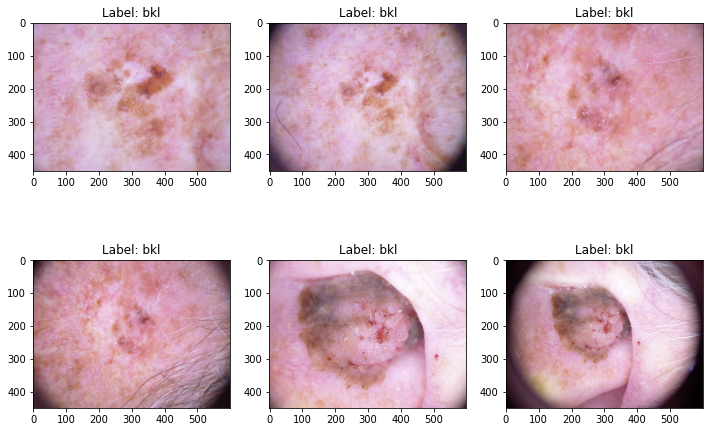

In [14]:
# Create a new TensorFlow Dataset with the first six elements.
example_test_imgs = dataset.take(6)

# Convert the dataset into a list of Dataset elements which are numpy arrays. 
# Note: each element is a tuple containing a numpy array of image pixels followed by the 
# label  
ls_example_test_imgs =  list(example_test_imgs.as_numpy_iterator())

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

ct_row = 0
ct_col = 0

# We must extract the 3 dimensional array of pixels for each image and it's label from the list.
for element in ls_example_test_imgs:

    img = element[0]
    lbl = element[1]

    axs[ct_row, ct_col].imshow(img)
    axs[ct_row, ct_col].set_title(f'Label: {dict_rev_lesion_mp[lbl]}')
    ct_col += 1
    
    if ct_col == 3:
        ct_col = 0
        ct_row += 1

### Split in training and test

In [15]:
DATASET_SIZE = 10015

train_size = int(0.7 * DATASET_SIZE)
test_size = int(0.3 * DATASET_SIZE)


full_dataset = dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)

In [16]:
print(f'Number of training images: {train_dataset.cardinality().numpy()}')
print(f'Number of test images: {test_dataset.cardinality().numpy()}')


Number of training images: 7010
Number of test images: 3004


### Take a look at images from the training dataset

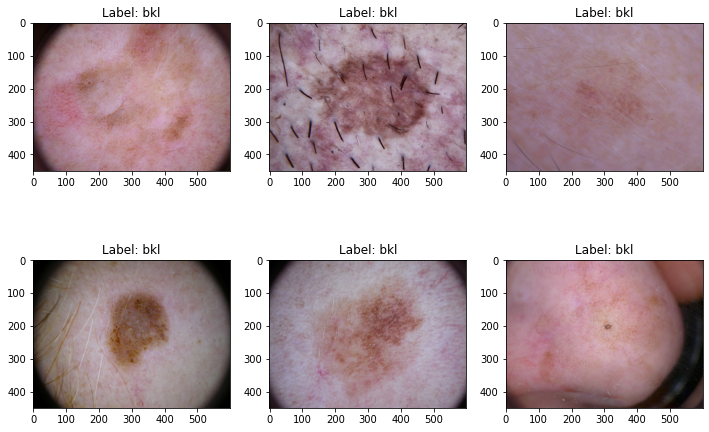

In [17]:
# Create a new TensorFlow Dataset with the first six elements.
train_ds_examples = train_dataset.take(6)

# Convert the dataset into a list of Dataset elements which are numpy arrays. 
# Note: each element is a tuple containing a numpy array of image pixels followed by the 
# label  
ls_train_ds_examples =  list(train_ds_examples.as_numpy_iterator())

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

ct_row = 0
ct_col = 0

# We must extract the 3 dimensional array of pixels for each image and it's label from the list.
for element in ls_train_ds_examples:

    img = element[0]
    lbl = element[1]

    axs[ct_row, ct_col].imshow(img)
    axs[ct_row, ct_col].set_title(f'Label: {dict_rev_lesion_mp[lbl]}')
    ct_col += 1
    
    if ct_col == 3:
        ct_col = 0
        ct_row += 1



### Take a look at the first 6 test images

In [ ]:
# Create a new TensorFlow Dataset with the first six elements.
test_ds_examples = test_dataset.take(6)

# Convert the dataset into a list of Dataset elements which are numpy arrays. 
# Note: each element is a tuple containing a numpy array of image pixels followed by the 
# label  
ls_test_ds_examples =  list(test_ds_examples.as_numpy_iterator())

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

ct_row = 0
ct_col = 0

# We must extract the 3 dimensional array of pixels for each image and it's label from the list.
for element in ls_test_ds_examples:

    img = element[0]
    lbl = element[1]

    axs[ct_row, ct_col].imshow(img)
    axs[ct_row, ct_col].set_title(f'Label: {dict_rev_lesion_mp[lbl]}')
    ct_col += 1
    
    if ct_col == 3:
        ct_col = 0
        ct_row += 1

### Build a simple CNN

In [18]:
# Instantiate a sequential model instance
model = Sequential()

# Specify a layer that takes the input with input shape
model.add(Input(shape=(450, 600, 3)))

# Add a convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Add a convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Add a convolutional layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True))
             
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Add a convolutional layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flatten the results
model.add(Flatten())

# Add a dense layer
model.add(Dense(256, activation='relu'))

# Add an output layer with 7 nodes and softmax activation
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 600, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 200, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 200, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 66, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 66, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 22, 128)      0

### Batch the test and training sets

In [19]:
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
from sklearn.utils import class_weight

arr_classes = []

# We must extract the 3 dimensional array of pixels for each image and it's label from the list.
for i, element in enumerate(train_dataset.as_numpy_iterator()): 

    for j in element[1]:

      arr_classes.append(j)


class_weights = dict(zip(np.unique(arr_classes), 
                         class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(arr_classes), y=arr_classes)))

class_weights

{0: 1.0679463741620963,
 1: 0.2891914191419142,
 2: 10.159420289855072,
 3: 1.0554049984944294,
 4: 8.227699530516432,
 5: 2.2819010416666665}

### Use Early stopping to stop training if the loss doesn't change over 3 Epoch's

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

### Fit the model on the training set and test on the validation set.

In [1]:
# Fit the model on the train data with 20 epochs
history = model.fit(x=train_dataset, epochs=20, verbose=1, validation_data=test_dataset, class_weight=class_weights, callbacks=[callback], use_multiprocessing=True)

NameError: ignored

In [ ]:
print(history.history.keys())


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ls_epochs = np.arange(1, 5)

_ = axs[0].plot(ls_epochs, history.history['loss'], label='Training Loss', color='orange')
_ = axs[0].plot(ls_epochs, history.history['val_loss'], label='Validation Loss', color='green')
_ = axs[0].set_xlabel('Epoch Number', fontsize=12)
_ = axs[0].set_ylabel('Loss', fontsize=12)
_ = axs[0].set_title('Loss as a Function of Epoch', fontsize=18)
_ = axs[0].set_xticks(ls_epochs)
_ = axs[0].legend(loc='upper right')

_ = axs[1].plot(ls_epochs, history.history['accuracy'], label='Training Accuracy', color='orange')
_ = axs[1].plot(ls_epochs, history.history['val_accuracy'], label='Validation Accuracy', color='green')
_ = axs[1].set_xlabel('Epoch Number', fontsize=12)
_ = axs[1].set_ylabel('Accuracy', fontsize=12)
_ = axs[1].set_title('Accuracy as a Function of Epoch', fontsize=18)
_ = axs[1].set_xticks(ls_epochs)
_ = axs[1].legend(loc='upper right')

### Save the model

In [ ]:
# Save the model.

model_name = '220716_simple_cnn_1'
model_path = os.path.join('content', 'drive', 'MyDrive', 'saved_models', model_name)
model.save(model_path)

### Let's confirm the accuracy on the test dataset

In [ ]:
accuracy_test = model.evaluate(test_dataset)

In [ ]:
accuracy_test

### Use the model to make one prediction on an image.

In [ ]:
# Note: As a tf dataset is used to train we need to read the iamge into a tensor data type
image_string = tf.io.read_file('/content/drive/MyDrive/archive/lesions/ISIC_0024306.jpg')
image_decoded = tf.image.decode_jpeg(image_string, channels=3)
image = tf.cast(image_decoded, tf.float32)/255
image.shape

__The model expects 4 dimensions with the first being the batch. However, an image only has 3 dimensions so we need to add a demensions to axis 0 for the batch.__

In [ ]:
image = tf.expand_dims(input=image, axis=0, name=None)
image.shape

In [ ]:
img_pred = model(image)
img_pred = img_pred.numpy()
img_pred_proba = img_pred * 100
img_pred_proba = img_pred_proba.ravel()

*Make sure the probabilities sum to 100*

In [ ]:
np.sum(img_pred_proba)

In [ ]:
ls_lesion_classes = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

idx_max = np.argmax(img_pred_proba)


print(f'Models predicts the image as {ls_lesion_classes[idx_max]} with a probability of {round(img_pred_proba[idx_max], 3)}')
print(f'The actual skin lesion class is nv')

### To load this model... Uncomment code and run this cell where you want to in the notebook

In [ ]:
model_name = '220716_simple_cnn_1'
model = models.load_model(os.path.join('content', 'drive', 'MyDrive', 'saved_models', model_name))